## Activation Functions

```text

```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import create_iris_data, smooth, load_data
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
fp = "../../data/wine_data.csv"

data = load_data(filename=fp)
data.head()

Shape of data: (1599, 12)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Preprocess Data

```text
- Standardize/normalize the data.
- Binarize the output.
- Split the data using hold out CV.
- Create PyTorch datasets and dataloader objects.
- Create a custom class that supports batch normalization.
- Train and evaluate the model.
- Visualize the model results.
```

In [3]:
# Select all the features bar the target.
X = data.iloc[:, :-1]

# Normalize the data
norm_ = Normalizer(min_value=0, max_value=1)
X_norm = norm_.fit_transform(X=X)

X_norm.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846


In [4]:
# Binarize output
choice_list = [0, 1]

# 3, 4, and 5 : 0, else 1
data["target"] = np.where(
    data["quality"].isin(np.arange(3, 6)), choice_list[0], choice_list[1]
)

data[["quality", "target"]].sample(5, random_state=5)

,quality,target
236,6,1
833,4,0
424,5,0
982,6,1
1155,5,0


In [5]:
# Convert to Tensors
X = torch.Tensor(X_norm.to_numpy())

# Requred by PyTorch to be 2D instead of 1D
y = torch.Tensor(data["target"].to_numpy()).reshape(-1, 1)

# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([1279, 11]), torch.Size([320, 11]))

In [6]:
BATCH_SIZE, SHUFFLE = 16, True
DROP_LAST = True


# Create PyTorch datasets and dataloader objects.
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST
)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
)

In [7]:
activation_functions = ["sigmoid", "tanh", "relu"]

for func in activation_functions:
    print(f"{func}: {getattr(torch, func)}\n")

sigmoid: <built-in method sigmoid of type object at 0x13c28d820>

tanh: <built-in method tanh of type object at 0x13c28d820>

relu: <built-in method relu of type object at 0x13c28d820>



In [8]:
input_value = torch.tensor(2.5)
sigmoid_func = getattr(torch, "sigmoid")

sigmoid_func(input_value)

tensor(0.9241)

In [9]:
tanh_func = getattr(torch, "tanh")
tanh_func(input_value)

tensor(0.9866)

In [10]:
relu_func = getattr(torch, "relu")
relu_func(input_value)

tensor(2.5000)

In [11]:
class Net(nn.Module):
    """This is an ANN architecture with an argument for activation functions."""

    def __init__(self, activation_func: str) -> None:
        super().__init__()
        self.activation_func = activation_func
        self.input = nn.Linear(11, 32)
        self.hidden = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward propagation."""
        act_func = getattr(torch, self.activation_func)
        X = act_func(self.input(X))
        X = act_func(self.hidden(X))
        X = torch.sigmoid(self.output(X))
        return X


# Train ANN model
def train_model(
    *,
    activation_func: str,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
) -> tuple[float, float, float]:
    """This is used to train an ANN model with batch normalization."""
    LEARNING_RATE, EPOCHS = 0.01, 1_000
    THRESH, PCT = 0.5, 100

    net = Net(activation_func=activation_func)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=LEARNING_RATE)
    criterion, train_loss = nn.BCELoss(), []
    train_accuracy, validation_accuracy = [], []

    for _ in np.arange(EPOCHS):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Compute forward prop and loss
            y_proba = net(X_)
            loss: torch.Tensor = criterion(y_proba, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch metrics
            acc = torch.mean(((y_proba > THRESH) == y_).float()) * PCT
            batch_accuracy.append(acc.detach())
            batch_loss.append(loss.detach())

        # Train metrics
        train_accuracy.append(np.mean(batch_accuracy))
        train_loss.append(np.mean(batch_loss))

        # Validation metrics
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val = net(X_val)
        acc = torch.mean(((y_proba_val > THRESH) == y_val).float()) * PCT
        validation_accuracy.append(acc.detach())

    return (train_accuracy, validation_accuracy, train_loss)

In [12]:
train_accuracy, validation_accuracy, train_loss = train_model(
    activation_func="relu",
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
)

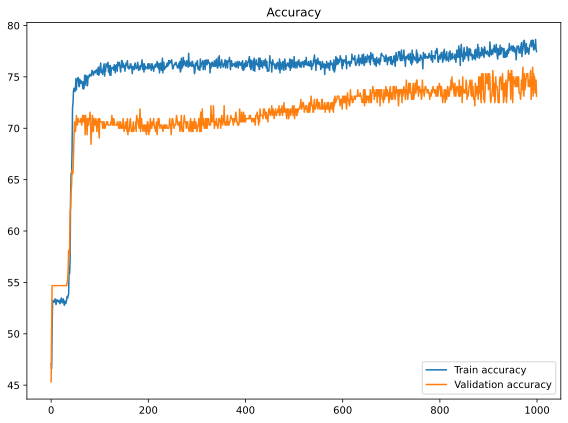

In [13]:
# Visualize the results
plt.figure(figsize=(8, 6))

plt.plot(train_accuracy, label="Train accuracy")
plt.plot(validation_accuracy, label="Validation accuracy")
plt.title("Accuracy")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Parametric Experiment With Different Activation Functions

In [14]:
EPOCHS, activation_funcs = 1_000, ["relu", "tanh", "sigmoid"]
train_accuracy, validation_accuracy = (
    np.zeros(shape=(EPOCHS, len(activation_funcs))),
    np.zeros(shape=(EPOCHS, len(activation_funcs))),
)


for idx, act_func in enumerate(activation_funcs):
    train_acc_, validation_acc_, train_loss = train_model(
        activation_func=act_func,
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
    )
    train_accuracy[:, idx] = train_acc_
    validation_accuracy[:, idx] = validation_acc_

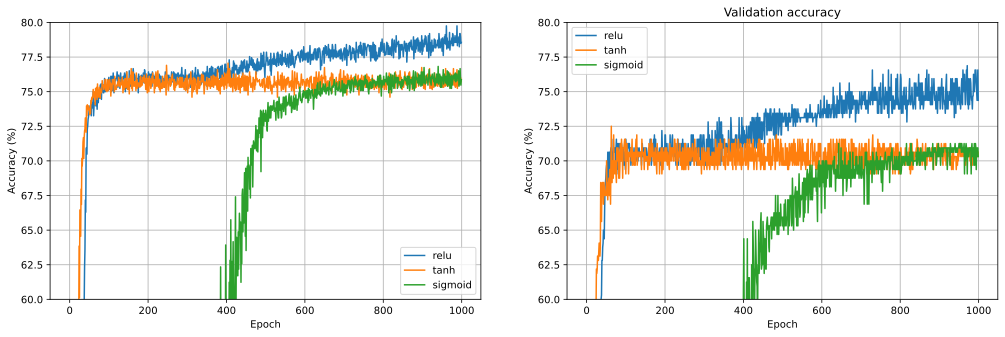

In [15]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_accuracy)
ax[1].set_title("Train accuracy")

ax[1].plot(validation_accuracy)
ax[1].set_title("Validation accuracy")

# Common features
for idx in range(2):
    ax[idx].legend(activation_funcs)
    ax[idx].set_xlabel("Epoch")
    ax[idx].set_ylabel("Accuracy (%)")
    ax[idx].set_ylim(60, 80)
    ax[idx].grid()

plt.show()

### Compare ReLU Variants

```text
- Update the model architecture: 
```

```python
# From: torch
act_func = getattr(torch, self.activation_func)

# To: torch.nn
 act_func = getattr(torch.nn, self.activation_func)
```

In [16]:
# torch
try:
    print(getattr(torch, "LeakyReLU"))
except AttributeError as err:
    print(err)

module 'torch' has no attribute 'LeakyReLU'


In [17]:
# torch.nn
try:
    print(getattr(torch.nn, "LeakyReLU"))
except AttributeError as err:
    print(err)

<class 'torch.nn.modules.activation.LeakyReLU'>


In [18]:
class Net(nn.Module):
    """This is an ANN architecture with an argument for activation functions."""

    def __init__(self, activation_func: str) -> None:
        super().__init__()
        self.activation_func = activation_func
        self.input = nn.Linear(11, 32)
        self.hidden = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to implement forward propagation."""
        act_func = getattr(torch.nn, self.activation_func)
        X = act_func()(self.input(X))
        X = act_func()(self.hidden(X))
        X = torch.sigmoid(self.output(X))
        return X

In [19]:
train_DL

In [20]:
EPOCHS, activation_funcs = 1_000, ["ReLU", "ReLU6", "LeakyReLU"]
train_accuracy, validation_accuracy = (
    np.zeros(shape=(EPOCHS, len(activation_funcs))),
    np.zeros(shape=(EPOCHS, len(activation_funcs))),
)


for idx, act_func in enumerate(activation_funcs):
    train_acc_, validation_acc_, train_loss = train_model(
        activation_func=act_func,
        train_dataloader=train_DL,
        validation_dataloader=validation_DL,
    )
    train_accuracy[:, idx] = train_acc_
    validation_accuracy[:, idx] = validation_acc_

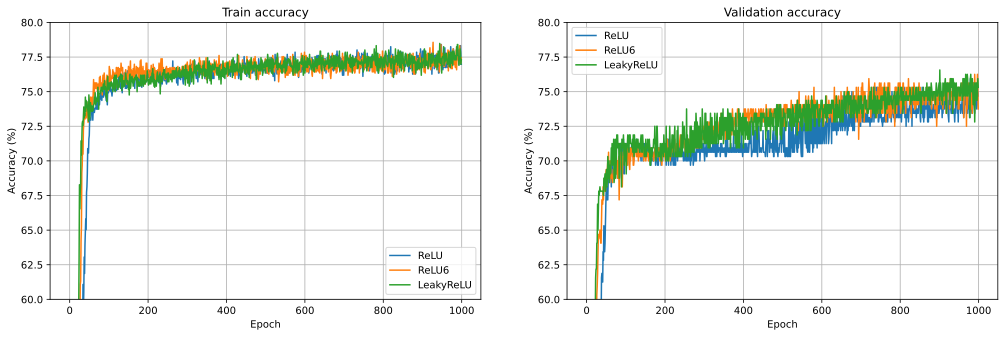

In [21]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_accuracy)
ax[0].set_title("Train accuracy")

ax[1].plot(validation_accuracy)
ax[1].set_title("Validation accuracy")

# Common features
for idx in range(2):
    ax[idx].legend(activation_funcs)
    ax[idx].set_xlabel("Epoch")
    ax[idx].set_ylabel("Accuracy (%)")
    ax[idx].set_ylim(60, 80)
    ax[idx].grid()

plt.show()